# Milestone 2

### Part 1: Getting familiar with the data and constructing the Story Arcs

In this section, we will start by reading the plot summaries dataset and storing it in a dataframe. We will then proceed by tokinizing the movie plots into sentances and running sentiment analysis on every line. With that, we will proceed by reading the movie meta dataset storing it in a dataframe. We will merge the two datasets on a common ID and with that, we will merge the two datasets and group the movies by Genre. 

#### Part 1.1: Plot Summary dataset (pre-processing + sentiment retrieval)

In [ ]:
# Install the necessary libraries
%pip install nltk
%pip install vaderSentiment
%pip install tslearn

In [54]:
#Imports that are needed for the project
from itertools import zip_longest
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tslearn.clustering import KernelKMeans
from tslearn.utils import to_time_series_dataset
from scipy.signal import savgol_filter
import pandas as pd
from nltk import tokenize
import matplotlib.pyplot as plt
from typing import List, Dict
import json

In [55]:
# Read the Movie Summary Dataset
df_plots = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header=None, names = ['id', 'plot'])

# Display the first 5 elements of the dataframe
df_plots.head(5)

,id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [56]:
#Tranform plots into arrays of sentences using the ntlk library
df_plots['plot_sentances']= df_plots['plot'].apply(lambda t: tokenize.sent_tokenize(t))
df_plots.head(2)

,id,plot,plot_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...


In [73]:
# instantiate the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# classify the sentiment into one of 3 classes (positive, negative, neutral)
def classify(compound: float):
    if compound >= 0.05:
        #positive
        return 1
    elif compound <= -0.05:
        #negative
        return -1
    #neutral
    return 0

# given a list of sentances, return the result of the analyzer
def analyse_text(paragraph, classify_discrete = True): 
    res = []
    for sentence in paragraph:
        sentiment_result = analyzer.polarity_scores(sentence)
        if classify_discrete:
            res.append(classify(sentiment_result['compound']))
        else:
            res.append(sentiment_result['compound'])
    
    window = int(len(res)/6)
    window = window + 1 if window%2 == 0 else window 
    
    return savgol_filter(res, window_length=window, polyorder=3) if window>3 else res

In [74]:
# Compute the plot sentitiment discrete classes and continuous scores 
df_plots["plot_classification"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t))
df_plots["plot_scores"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t, classify_discrete=False))

In [75]:
# display the first 5 elements to view the newly added columns
df_plots.head(5)

,id,plot,plot_sentances,plot_classification,plot_scores
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh...",[0],[0.0083]
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...,"[-0.37373737373737465, 0.1111111111111095, 0.1...","[-0.22422929292929272, 0.01196919191919163, 0...."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[Poovalli Induchoodan is sentenced for six ye...,"[-0.8857142857142764, 0.5428571428571425, -0.3...","[-0.8036999999999926, 0.34680000000000144, 0.0..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The Lemon Drop Kid , a New York City swindler...","[-0.23232323232323157, -0.06565656565656622, 0...","[-0.08758181818181772, -0.2674106060606062, -0..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[Seventh-day Adventist Church pastor Michael C...,"[1, 1, 1, -1, 1, 0, -1, 1, -1, -1, -1, 1, -1, ...","[0.4019, 0.0772, 0.2732, -0.6367, 0.4215, 0.0,..."


#### Part 1.2: Movie Metadata dataset (pre-processing + merging)

In [76]:
# read the movie meta-data dataset
df_metadatas = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t', names=["id", "FreebaseId", "Title", "release date", "boxOffice", "Runtime", "language", "country", "genres"])
df_metadatas.head(5)

,id,FreebaseId,Title,release date,boxOffice,Runtime,language,country,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [77]:
processed_df = df_metadatas.merge(df_plots, left_on="id", right_on='id')[['id', 'plot', 'release date', 'Title', 'boxOffice', 'plot_classification', 'plot_scores', "country", "genres"]]
processed_df.head(5)

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres
0,975900,"Set in the second half of the 22nd century, th...",2001-08-24,Ghosts of Mars,14010832.0,"[1, 1, -1, -1, 1, 0, -1, -1, -1, 0, 1, -1, -1,...","[0.2235, 0.144, -0.5423, -0.296, 0.25, 0.0, -0...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-0.8571428571428745, 0.7619047619047563, 0.69...","[-0.6641833333333406, 0.3856095238095242, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
2,261236,"Eva, an upper class housewife, becomes frustra...",1983,A Woman in Flames,NaN,"[-0.9285714285714307, -0.28571428571428514, 0....","[-0.7030200000000022, -0.2479199999999998, 0.3...","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
3,18998739,"Every hundred years, the evil Morgana returns...",2002,The Sorcerer's Apprentice,NaN,"[-1, -1, 0, 1, 1, -1, -1]","[-0.836, -0.5106, 0.0, 0.6486, 0.3182, -0.3612...","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
4,6631279,"Adam, a San Francisco-based artist who works a...",1997-04-04,Little city,NaN,"[0, -1, 1, 0, -1, -1, 0, 0, -1]","[-0.0258, -0.3612, 0.6705, 0.0, -0.4404, -0.12...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ..."


In [78]:
# count the number of movies that we already have in the dataset after the merge 
initial_size_of_the_dataset = len(processed_df)
print(f"The initial size of the dataset : {initial_size_of_the_dataset}")

# drop the rows that have no box office revenues (we are interrested in the profitability of story arcs)
processed_df.dropna(subset=["boxOffice"], inplace=True)
size_of_the_dataset = len(processed_df)
print(f"The size of the dataset after removing movies that have no revenue values: {size_of_the_dataset}")

The initial size of the dataset : 42204
The size of the dataset after removing movies that have no revenue values: 7587


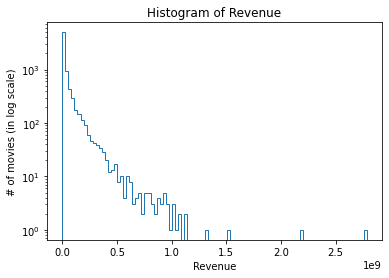

In [79]:
# let us plot the distribution of the box office revenue of different movies
plt.hist(processed_df['boxOffice'],bins=100,log=True,histtype='step')
plt.title('Histogram of Revenue')
plt.ylabel('# of movies (in log scale)')
plt.xlabel('Revenue')
plt.show()

Now since the movie arcs are highly dependant on the genre, we will divide our dataset into 4 different dataframes where each data frame contain only the genre that we are interrested in. Yet movies, tend not to belong to only one genre but to multiple genres. Accordingly, we splitted the dataset in a mutually exclusive mannar. Specifically, when we are constructing a dataframe of a genre of interest, we made sure that the choosen movies does not share any other genre of interest besides the constructed one.

In [80]:
genres_of_interest =  ["adventure", "drama", "comedy", "action", "thriller", "science fiction", "costume adventure", "romance comedy"]

# In this part, we create different dataframes for the most common genres (1. Adventure, 2. Action, 3. Drama, 4. Comedy)
def is_needed_genre(genre_movie: Dict[str, str],genres_to_match: str):
        # get list of genres present in the movie
        list_of_genres_in_movie = list(genre_movie.values())

        # get list of genres to discard to avoid duplicates
        genres_to_discard = [genre for genre in genres_of_interest if genre not in genres_to_match]
        
        # flags to be used
        contains_needed_genre = False
        contains_not_needed_genres = False
        
        # iterate over all genres present in the movies
        for genre in list_of_genres_in_movie:
            # check if there is a match
            if (genre.lower() in genres_to_match):
                contains_needed_genre = True
            
            if (genre.lower() in genres_to_discard):
                contains_not_needed_genres = True
        
        # return True only if meets the following criteria
        return (contains_needed_genre) and (not contains_not_needed_genres)

# create column for every genre needed (Here we choose the Top 4 genres present)
processed_df["action"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["action", "thriller"]))
processed_df["adventure"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["adventure", "science fiction", "costume adventure"]))
processed_df["drama"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["drama"]))
processed_df["comedy"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["comedy", "romance comedy"]))

In [81]:
# create the action dataframe
action_df = processed_df[processed_df["action"]]

# create the adventure dataframe
adventure_df = processed_df[processed_df["adventure"]]

# create the drama dataframe
drama_df = processed_df[processed_df["drama"]]

# create the comedy dataframe
comedy_df = processed_df[processed_df["comedy"]]

In [82]:
# Let us visualize the size of the constructed dataset
print(f"The size of the action dataset is {len(action_df)}")
print(f"The size of the adventure dataset is {len(adventure_df)}")
print(f"The size of the drama dataset is {len(drama_df)}")
print(f"The size of the comedy dataset is {len(comedy_df)}")

The size of the action dataset is 632
The size of the adventure dataset is 195
The size of the drama dataset is 1631
The size of the comedy dataset is 1205


Text(0.04, 0.5, 'Sentiment Value')

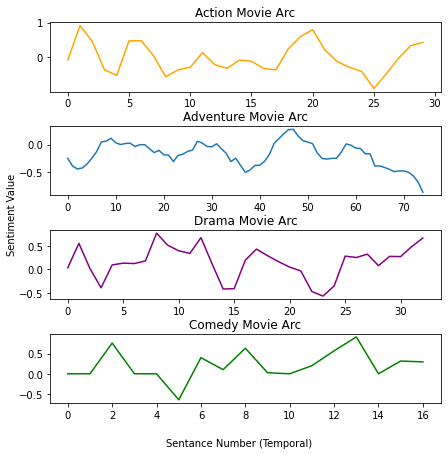

In [84]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(4, figsize=(7,7))
# plot the random adventure movie arc
axis[0].plot(list(action_df.iloc[11]["plot_scores"]), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(list(adventure_df.iloc[10]["plot_scores"]))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(list(drama_df.iloc[5]["plot_scores"]), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(list(comedy_df.iloc[14]["plot_scores"]), color="green")
axis[3].set_title("Comedy Movie Arc")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

Text(0.04, 0.5, 'Sentiment Value')

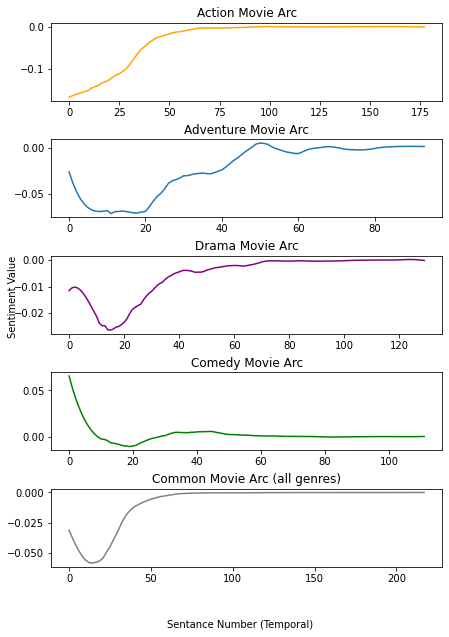

In [85]:
# TODO: Visualize the most common movie arc in each genre (by taking average of all the datapoints)
def get_most_common_movie_arc(series_frame):
    dictionary = series_frame.to_dict()
    list_values = [emotional_arc for emotional_arc in dictionary.values()]
    columns = zip_longest(*list_values, fillvalue=0)
    return [sum(col)/len(list_values) for col in columns]     

fig, axis = plt.subplots(5, figsize=(7,10))
# plot the random adventure movie arc
axis[0].plot(savgol_filter(get_most_common_movie_arc(action_df["plot_scores"]), 21,3), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(savgol_filter(get_most_common_movie_arc(adventure_df["plot_scores"]), 21 ,3))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(savgol_filter(get_most_common_movie_arc(drama_df["plot_scores"]), 21 ,3), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(savgol_filter(get_most_common_movie_arc(comedy_df["plot_scores"]), 21 ,3), color="green")
axis[3].set_title("Comedy Movie Arc")

axis[4].plot(savgol_filter(get_most_common_movie_arc(processed_df["plot_scores"]), 21 ,3), color="gray")
axis[4].set_title("Common Movie Arc (all genres)")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")



In [ ]:
def form_features(series_frame):
    dictionary = series_frame.to_dict()
    list_values = [emotional_arc for emotional_arc in dictionary.values()]
    return to_time_series_dataset(list_values)

# cluster the action genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(action_df["plot_scores"]))
action_df["cluster_id"] = labels_gak

# cluster the adventure genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(adventure_df["plot_scores"]))
adventure_df["cluster_id"] = labels_gak

# cluster the drama genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(drama_df["plot_scores"]))
drama_df["cluster_id"] = labels_gak

# cluster the drama genre time series
gak_km = KernelKMeans(n_clusters=3, kernel="gak")
labels_gak = gak_km.fit_predict(form_features(comedy_df["plot_scores"]))
comedy_df["cluster_id"] = labels_gak

Text(0.02, 0.5, 'Sentiment Value')

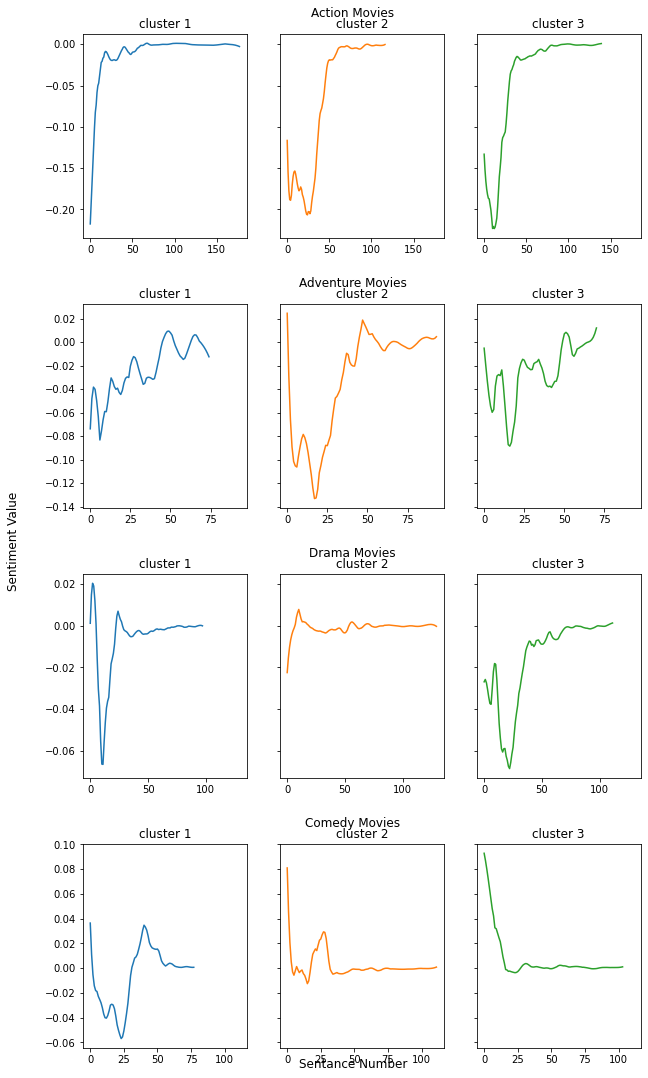

In [108]:
fig = plt.figure(figsize = (10,15))

# form data loader of the different clusters 
dataset_by_genre = {"Action": action_df, "Adventure": adventure_df, "Drama":drama_df, "Comedy":comedy_df}

subfigs = fig.subfigures(nrows=4, ncols=1)
for index, jointed_genres in enumerate(zip(dataset_by_genre.keys(), subfigs)):
    jointed_genres[1].suptitle(f"{jointed_genres[0]} Movies")
    groued_dataset = dataset_by_genre[jointed_genres[0]].groupby("cluster_id")
    colors = plt.rcParams["axes.prop_cycle"]()

    # create 1x3 subplots per subfig
    axs = jointed_genres[1].subplots(nrows=1, ncols=3, sharex=True, sharey=True)
    for key in groued_dataset.groups.keys():

        # get color
        c = next(colors)["color"]
        common_featurs= savgol_filter(get_most_common_movie_arc(groued_dataset.get_group(key)["plot_scores"]), 11, 3)

        # filter value
        axs[key].plot(common_featurs, color=c)
        axs[key].set_title(f"cluster {key + 1}")

# common axis label
fig.supxlabel('Sentance Number')
fig.supylabel('Sentiment Value')

### Part 2: From the provided dataset to our sicentific question

#### Part 2.1: Emotional vs Non-emotional movies (ratings)

#### Part 2.2: Positive vs Negative movies (ratings)

#### Part 2.3: Most profitable movie arc per genre (box office)

#### Part 2.4: Most rated movie arc per genre (ratings)

In [ ]:
df_titles = pd.read_csv('Movieplots/titles.tsv', sep = '\t', low_memory=False)


In [ ]:
df_title = df_titles[df_titles['titleType'] == 'movie']

In [ ]:
df_title.head(5)

In [ ]:
df_ratings = pd.read_csv('MovieSummaries/ratings.tsv', sep = '\t')

In [ ]:
df_ratings.head(5)

In [ ]:
df_imdb = df_title.merge(df_ratings, left_on='tconst', right_on='tconst')

In [ ]:
df_imdb= df_imdb[['originalTitle', 'averageRating', 'numVotes']]

In [ ]:
df_imdb.head(5)

In [ ]:
#Need to verify if Title and originalTitle can be used to merge
df = df.merge(df_imdb, left_on='Title', right_on='originalTitle')

In [ ]:
df = df[['Title', 'plot', 'release date', 'averageRating', 'numVotes']]

In [ ]:
df.shape[0]

In [ ]:
#Remove rows where box office is Nan
df = df.loc[pd.notnull(df.boxOffice)]

In [ ]:
# Throws an error if we try to convert 1010-12-02 into DateTime 
df = df[df['release date'] != '1010-12-02']

In [ ]:
df['release date'] = pd.to_datetime(df['release date'])
df['release date'] = df['release date'].dt.year

In [ ]:
df.head(5)